In [ ]:
# Importing the required libraries
import os  # To handle directory and file path operations
import numpy as np  # For array handling and numerical computations
from PIL import Image, ImageEnhance, ImageFilter  # For image processing
import tensorflow as tf  # For building and training neural network models
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmenting image data
import matplotlib.pyplot as plt  # For visualizing images and results
import logging  # For logging information, especially useful for corrupted images

# Set up logging to record any corrupted images
logging.basicConfig(level=logging.INFO, filename='corrupted_images.log', filemode='w')  # Logging setup to store messages in a file
logger = logging.getLogger()  # Initializing a logger instance

In [ ]:
# Function to safely load an image and apply optional processing
def load_image_safe(filepath, apply_processing=None):
    try:
        img = Image.open(filepath)  # Open the image file
        img = img.resize((224, 224))  # Resize image to 224x224 for model compatibility
        
        # Apply specified processing if requested
        if apply_processing == "contrast":
            img = ImageEnhance.Contrast(img).enhance(1.5)  # Increase contrast by a factor of 1.5
        elif apply_processing == "blur":
            img = img.filter(ImageFilter.GaussianBlur(1))  # Apply Gaussian blur with radius 1
        elif apply_processing == "edge":
            img = img.filter(ImageFilter.EDGE_ENHANCE)  # Enhance edges in the image
        
        img = img.convert("RGB")  # Convert image to RGB format to ensure consistency
        return np.array(img) / 255.0  # Normalize pixel values to the range [0,1]
    except Exception as e:
        # Log corrupted image and skip
        logger.info(f"Corrupted image skipped: {filepath} | Error: {e}")
        return None  # Return None if loading fails

In [ ]:
# Generator function to safely yield batches of images for training
def safe_image_generator(directory, image_size=(224, 224), batch_size=32, class_mode='binary', apply_processing=None):
    datagen = ImageDataGenerator(rescale=1./255)  # Initialize data generator with rescaling
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,  # Resize images to specified size
        batch_size=batch_size,  # Set batch size for training
        class_mode=class_mode,  # Define the label mode, binary for two classes
        shuffle=True  # Shuffle data at each epoch
    )

    # Infinite loop for yielding batches of processed images
    while True:
        batch_data, batch_labels = generator.next()  # Get next batch of images and labels
        valid_images = []  # List to store valid (uncorrupted) images
        valid_labels = []  # List to store labels corresponding to valid images
        for i in range(len(batch_data)):
            img_path = generator.filepaths[generator.index_array[i]]  # Get file path for each image in batch
            img = load_image_safe(img_path, apply_processing)  # Load image with optional processing
            if img is not None:  # Add only if image is successfully loaded
                valid_images.append(img)
                valid_labels.append(batch_labels[i])
        if valid_images:
            yield np.array(valid_images), np.array(valid_labels)  # Yield valid images and labels as batch

In [ ]:
# Function to create a simple CNN model
def create_model():
    model = tf.keras.models.Sequential([  # Define a Sequential model
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters
        tf.keras.layers.MaxPooling2D(2, 2),  # Max pooling layer
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with 64 filters
        tf.keras.layers.MaxPooling2D(2, 2),  # Second max pooling layer
        tf.keras.layers.Flatten(),  # Flatten layer to convert 2D output to 1D
        tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Compile the model
    return model  # Return compiled model

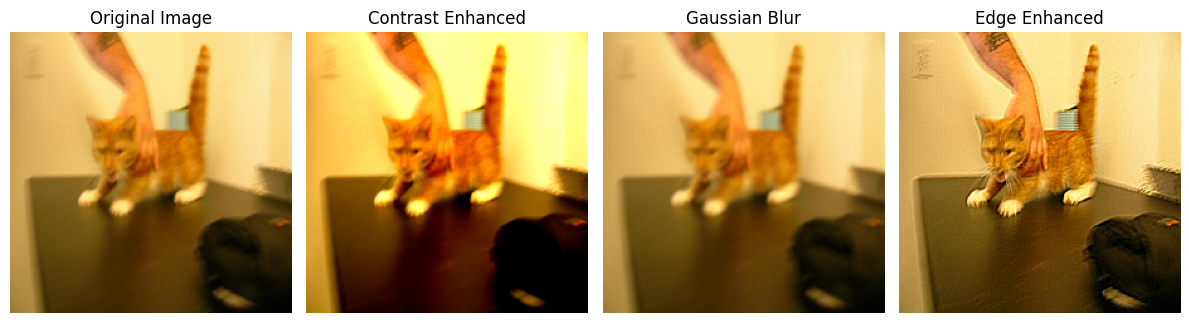

In [ ]:
# Load sample image from the dataset for demonstration of processing
sample_directory = 'C:/Users/asus/Downloads/archive/kagglecatsanddogs_3367a/PetImages/Cat/'  # Path to image directory
sample_image_path = os.path.join(sample_directory, os.listdir(sample_directory)[0])  # Get path of first image in directory

# Apply different processing techniques on the sample image
original_img = load_image_safe(sample_image_path)  # Load original image
contrast_img = load_image_safe(sample_image_path, apply_processing="contrast")  # Load image with contrast enhancement
blurred_img = load_image_safe(sample_image_path, apply_processing="blur")  # Load image with Gaussian blur
edge_img = load_image_safe(sample_image_path, apply_processing="edge")  # Load image with edge enhancement

# Plot all processed images side by side for visual comparison
plt.figure(figsize=(12, 6))  # Define the plot size

# Display Original Image
plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')  # Hide axes

# Display Contrast-enhanced Image
plt.subplot(1, 4, 2)
plt.imshow(contrast_img)
plt.title("Contrast Enhanced")
plt.axis('off')

# Display Gaussian-blurred Image
plt.subplot(1, 4, 3)
plt.imshow(blurred_img)
plt.title("Gaussian Blur")
plt.axis('off')

# Display Edge-enhanced Image
plt.subplot(1, 4, 4)
plt.imshow(edge_img)
plt.title("Edge Enhanced")
plt.axis('off')

plt.tight_layout()  # Adjust layout for no overlapping
plt.show()  # Show the plot

In [ ]:
# Set directory path and parameters for training
directory_path = 'C:/Users/asus/Downloads/archive/kagglecatsanddogs_3367a/PetImages/'  # Main dataset directory
image_size = (224, 224)  # Size of each image
batch_size = 64  # Batch size for training

# Initialize and train the model without preprocessing
model_no_processing = create_model()  # Create a new model instance
train_data_gen = safe_image_generator(directory_path, image_size=image_size, batch_size=batch_size, apply_processing=None)  # Generator without processing
history_no_processing = model_no_processing.fit(train_data_gen, steps_per_epoch=100, epochs=5)  # Train model for 5 epochs

# Print the final accuracy without preprocessing
accuracy_no_processing = history_no_processing.history['accuracy'][-1]  # Get last epoch accuracy
print(f"Final accuracy without preprocessing: {accuracy_no_processing:.2f}")

Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 210s 2s/step - loss: 0.9062 - accuracy: 0.5023
Epoch 2/5
 81/100 [=======================>......] - ETA: 39s - loss: 0.6933 - accuracy: 0.4909

c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 [==============================] - 209s 2s/step - loss: 0.6933 - accuracy: 0.4917
Epoch 3/5
100/100 [==============================] - 205s 2s/step - loss: 0.6933 - accuracy: 0.4997
Epoch 4/5
100/100 [==============================] - 198s 2s/step - loss: 0.6932 - accuracy: 0.4976
Epoch 5/5
100/100 [==============================] - 185s 2s/step - loss: 0.6932 - accuracy: 0.5028
Final accuracy without preprocessing: 0.50


In [ ]:
#Repeat process with contrast enhancement
model_contrast = create_model()  # New model for contrast processing
train_data_gen_contrast = safe_image_generator(directory_path, image_size=image_size, batch_size=batch_size, apply_processing="contrast")  # Contrast generator
history_contrast = model_contrast.fit(train_data_gen_contrast, steps_per_epoch=100, epochs=5)  # Train model

# Print the final accuracy with contrast enhancement
accuracy_contrast = history_contrast.history['accuracy'][-1]  # Get last epoch accuracy
print(f"Final accuracy with contrast enhancement: {accuracy_contrast:.2f}")


Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 182s 2s/step - loss: 0.8995 - accuracy: 0.4989
Epoch 2/5
100/100 [==============================] - 186s 2s/step - loss: 0.6933 - accuracy: 0.5077
Epoch 3/5
100/100 [==============================] - 187s 2s/step - loss: 0.6934 - accuracy: 0.4986
Epoch 4/5
100/100 [==============================] - 191s 2s/step - loss: 0.6931 - accuracy: 0.5018
Epoch 5/5
100/100 [==============================] - 172s 2s/step - loss: 0.6937 - accuracy: 0.5008
Final accuracy with contrast enhancement: 0.50


In [ ]:
# Repeat process with Gaussian blur
model_blur = create_model()  # New model for Gaussian blur processing
train_data_gen_blur = safe_image_generator(directory_path, image_size=image_size, batch_size=batch_size, apply_processing="blur")  # Blur generator
history_blur = model_blur.fit(train_data_gen_blur, steps_per_epoch=100, epochs=5)  # Train model

# Print the final accuracy with Gaussian blur
accuracy_blur = history_blur.history['accuracy'][-1]  # Get last epoch accuracy
print(f"Final accuracy with Gaussian blur: {accuracy_blur:.2f}")

Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 178s 2s/step - loss: 0.8845 - accuracy: 0.4998
Epoch 2/5
100/100 [==============================] - 174s 2s/step - loss: 0.6932 - accuracy: 0.4961
Epoch 3/5
100/100 [==============================] - 188s 2s/step - loss: 0.6931 - accuracy: 0.5088
Epoch 4/5
100/100 [==============================] - 194s 2s/step - loss: 0.6932 - accuracy: 0.4999
Epoch 5/5
100/100 [==============================] - 176s 2s/step - loss: 0.6932 - accuracy: 0.4972
Final accuracy with Gaussian blur: 0.50


In [ ]:
# Repeat process with edge enhancement
model_edge = create_model()  # New model for edge enhancement processing
train_data_gen_edge = safe_image_generator(directory_path, image_size=image_size, batch_size=batch_size, apply_processing="edge")  # Edge generator
history_edge = model_edge.fit(train_data_gen_edge, steps_per_epoch=100, epochs=5)  # Train model

# Print the final accuracy with edge enhancement
accuracy_edge = history_edge.history['accuracy'][-1]  # Get last epoch accuracy
print(f"Final accuracy with edge enhancement: {accuracy_edge:.2f}")

Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 172s 2s/step - loss: 1.2330 - accuracy: 0.4992
Epoch 2/5
100/100 [==============================] - 189s 2s/step - loss: 0.6932 - accuracy: 0.4953
Epoch 3/5
100/100 [==============================] - 176s 2s/step - loss: 0.6932 - accuracy: 0.4903
Epoch 4/5
100/100 [==============================] - 179s 2s/step - loss: 0.6932 - accuracy: 0.4971
Epoch 5/5
100/100 [==============================] - 169s 2s/step - loss: 0.6932 - accuracy: 0.5036
Final accuracy with edge enhancement: 0.50


In [ ]:
# Summary of accuracies from all models
print(f"Accuracy without preprocessing: {accuracy_no_processing:.2f}")
print(f"Accuracy with contrast enhancement: {accuracy_contrast:.2f}")
print(f"Accuracy with Gaussian blur: {accuracy_blur:.2f}")
print(f"Accuracy with edge enhancement: {accuracy_edge:.2f}")

Accuracy without preprocessing: 0.50
Accuracy with contrast enhancement: 0.50
Accuracy with Gaussian blur: 0.50
Accuracy with edge enhancement: 0.50
